<a href="https://colab.research.google.com/github/jrosko/Cyano_ImgAnalysis/blob/main/analyse_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pims
import cv2
import sys
#from scipy import ndimage
from skimage.morphology import skeletonize
sys.path.insert(0, 'D:\\Cyano_ImgAnalysis\\functions\\')
# Import my functions library
import filaments as fil

## Load a test stack
## We're using the pims package to load tif stacks

path = r'D:\\Data_WW\\pos_6\\pos6_crop_1\\'
frames = pims.open(path + r'\*.tif')

Get all the skeletons from the video

In [2]:
skeletons = fil.get_skeletons(frames[0:100])

Produce a histogram of their masses

<function matplotlib.pyplot.show(close=None, block=None)>

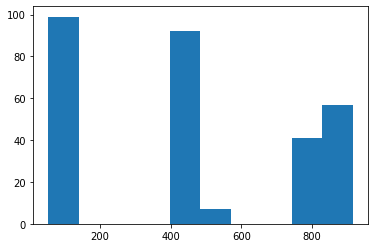

In [3]:
## Produce a mass histogram
masses = []
for k in range(0, len(skeletons)):
    masses.append(list(skeletons[str(k)].keys()))
masses_flat = [int(item) for sublist in masses for item in sublist] # need to remember that till now mass was string
masses_flat = np.array(masses_flat)
n, bins, patches = plt.hist(masses_flat)
plt.show


Now we want to group them by mass. There will be 3 groups, and I will make empty dictionaries for them

The format of the skeletons dictionary is:
{ 'n_frame' : { 'mass_1' : [*coordinates*],... }

In [4]:
# Dictionary comprehensions yaaay

mass_1 = {key:skeletons[key][mass] for key in skeletons.keys() for mass in skeletons[key].keys() if int(mass) < 200 }
mass_2 = {key:skeletons[key][mass] for key in skeletons.keys() for mass in skeletons[key].keys() if int(mass) > 300 and int(mass) < 600 }
mass_3 = {key:skeletons[key][mass] for key in skeletons.keys() for mass in skeletons[key].keys() if int(mass) > 650 }

now we have frame:coordinates dictionaries for all three masses. Let's pick a frame and plot the coordinates against a real image for a sanity check

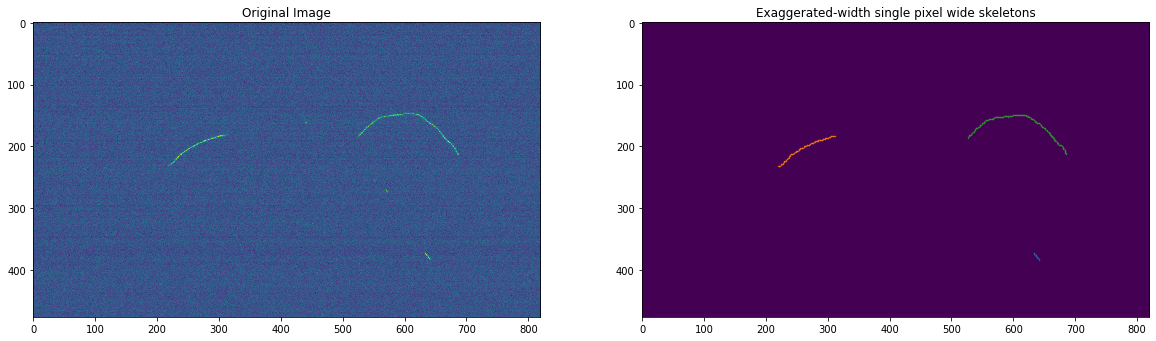

In [5]:
blank_img = np.zeros(frames[0].shape)

fig, ax = plt.subplots(1,2, figsize = (20,16))
ax[0].imshow(frames[1], interpolation = 'none')
ax[0].set_title('Original Image')
ax[1].imshow(blank_img)
ax[1].plot(mass_1['1'][:,1],mass_1['1'][:,0],'.', markersize=0.8)
ax[1].plot(mass_2['1'][:,1],mass_2['1'][:,0],'.', markersize=0.8)
ax[1].plot(mass_3['1'][:,1],mass_3['1'][:,0],'.', markersize=0.8)

ax[1].set_title('Exaggerated-width single pixel wide skeletons')
plt.show()

Now we gotta find the 'center' of each filament contour, so we can track and link them. First 'useful function' will find simple ends of a skeleton. First a function to order the points from one end to another, using the euclidean distance

In [6]:
def order_points(skeleton, frame):
    """ Need to clean this up, loadsa spaghetti code diomio """
    args = np.copy(skeleton)
    image = np.zeros(frame.shape) # fake imahe
    # now i reconstruct skeleton image with args
    for arg in args:
        image[arg[0], arg[1]]=1

    counter = 0
    reference_pt = 0
    
    for arg in args:
        if fil.nearest_neighbors(arg, image) == 3:
            counter = counter + 1
    for arg in args:
         if fil.nearest_neighbors(arg,image)==1:
             reference_pt = arg
             break

    if counter==0 and type(reference_pt)==type(np.array([])):
        #proceed with analysis
        #find simple ends
        norms = []
        # sort by euclidean norm
        for arg in args:
            norm = np.linalg.norm(arg.astype(np.float)-reference_pt.astype(np.float))
            norms.append(norm)
        norms = np.array(norms)
        normed_pts = np.insert(args, 2, norms, axis=1)
        sorted_column = normed_pts[:,2].argsort()
        # sort the normed pts by the sorted norm colum
        normed_pts = normed_pts[sorted_column]
        return normed_pts
    elif counter>0 or reference_pt==0:
        return None

In [7]:
# Ok so I want a function that takes in a dictionary
def midpoint_trace(input_dict):
    """ Compute a trace of single filament mid points through the image stack """
    outputs=[]
    frames_n = list(input_dict.keys())
    for n in range(1, len(frames_n)):
        filament = input_dict[frames_n[n-1]] # We start from zeroth filament
        ordered_skeleton = order_points(filament, frames[0])
        # 
        if type(ordered_skeleton) != type(None):
            mid_index = int(len(ordered_skeleton)/2)
            mid_point  = ordered_skeleton[mid_index][0:2]
            outputs.append([mid_point, int(frames_n[n-1])])
    return np.array(outputs, dtype=object)


mpt = midpoint_trace(mass_3)

Plot the midpoint trace against a frame

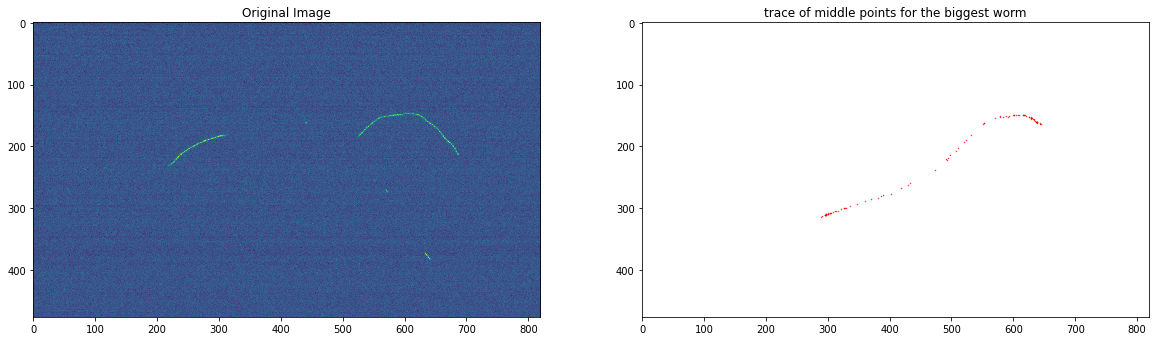

In [8]:
blank_img = np.zeros(frames[0].shape)

fig, ax = plt.subplots(1,2, figsize = (20,16))
ax[0].imshow(frames[1], interpolation = 'none')
ax[0].set_title('Original Image')
ax[1].imshow(blank_img, cmap='Greys')
x = [item[1] for item in mpt[:,0]]
y = [item[0] for item in mpt[:,0]]
ax[1].plot(x,y ,'.', markersize=0.8, color = 'red')

ax[1].set_title('trace of middle points for the biggest worm')
plt.show()

In [19]:
mpt[:,1][np.argwhere(mpt[:,1]==5)[0][0]-1]

4

In [24]:
# lets make function to compute a speed trace
def speedtrace(mpt,input_dict):
    # need also input dict to have the whole filament for reference
    # Iterate over midpoints
    first_vector = mpt[1][0] - mpt[0][0]
    result = []
    for frame in mpt[:,1].astype(np.int16)[1:]:
        #Get the respective filament from input dict
        filament =  input_dict[str(frame)] 
        filament = order_points(filament, frames[0])[:,0:2]

        current_pt = mpt[np.argwhere(mpt[:,1]==frame)[0][0]][0]
        prev_pt =    mpt[np.argwhere(mpt[:,1]==frame)[0][0]-1][0]
        motion_vector = current_pt - prev_pt
        ##calc dt
        dt = (frame  - mpt[:,1][np.argwhere(mpt[:,1]==frame)[0][0]-1])*5 # 5min

        single_result = []
        for point in filament:
            if np.dot(point - prev_pt, motion_vector) > 0:
                if np.sign(np.dot(current_pt - point, motion_vector)) >0:  # ii thought <0 but this works
                    single_result.append(point.tolist())

        #results.append(single_result) #if len(res) == 0: res.append(current_pt.tolist())
        #results now contains a set of ordered trajectories
        segment_len = fil.line_len(np.array(single_result), prev_pt, current_pt)
        result.append(segment_len*np.sign(np.dot(motion_vector, first_vector)))
    return np.array(result)*1.4748/dt



a = speedtrace(mpt, mass_3)



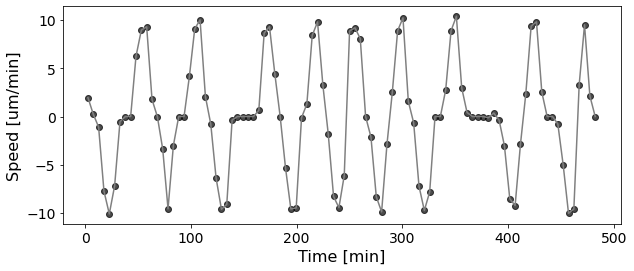

In [25]:
speed = a #np.array(a)*1.4748/5
fig=plt.figure()
fig.set_size_inches(10, 4)
plt.plot(np.linspace(0, len(speed)*5, len(speed))+2.5,speed, 'o', color='black', alpha=0.7)
plt.plot(np.linspace(0, len(speed)*5, len(speed))+2.5,speed,  '-', color='grey')
plt.xlabel('Time [min]', fontsize = 16)
plt.ylabel('Speed [um/min]', fontsize = 16)
plt.xticks(fontsize=14 )
plt.yticks(fontsize=14 )
plt.show()


Other 2 masses

In [26]:
mpt_1 = midpoint_trace(mass_1)
mpt_2 = midpoint_trace(mass_2)
speed_1 = speedtrace(mpt_1, mass_1)
speed_2 = speedtrace(mpt_2, mass_2)

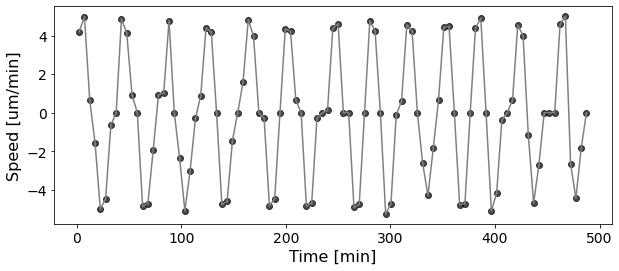

In [30]:
speed = speed_2
fig=plt.figure()
fig.set_size_inches(10, 4)
plt.plot(np.linspace(0, len(speed)*5, len(speed))+2.5,speed, 'o', color='black', alpha=0.7)
plt.plot(np.linspace(0, len(speed)*5, len(speed))+2.5,speed,  '-', color='grey')
plt.xlabel('Time [min]', fontsize = 16)
plt.ylabel('Speed [um/min]', fontsize = 16)
plt.xticks(fontsize=14 )
plt.yticks(fontsize=14 )
plt.show()